In [1]:
import nibabel as nib
import numpy as np
from sklearn.linear_model import Lasso,LassoCV,LinearRegression,Ridge
from sklearn.decomposition import TruncatedSVD, KernelPCA
from sklearn.gaussian_process import GaussianProcessRegressor
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import zoom
from math import sqrt
from sklearn.ensemble import AdaBoostRegressor,BaggingRegressor

from orelmisc import n_max,n_test_max,testpre,trainpre,saveCSV,y_org,shape_3d_org
from preprocess import flatten,flatten_each_sample,loadData,flatten_each_sample,precompute_and_save

In [2]:
prep = lambda i: i # int(i)
cap = lambda p: min(1,max(0,p))
def pred_to_rgb(p):
  p = cap(p)
  v = (p+0.1)/1.3
  return (1-v*v,v*v,0.2)

# Ideas:
# -> use gradient as proprocessing?

# TODO:
# -> split data into training and validation data.
#    otherwise we will have overfitting.

x_org = None
x_t_org = None
xa_org = None
d_org = None
y = y_org
y_mean = np.full(n_max,np.mean(y),dtype=np.float64)[:n_test_max]
y_t_pred = None
y_t_pp = None
y_age = np.array([20, 25, 61, 84, 23, 69, 83, 62, 72, 52, 52, 25, 19, 70, 26, 83, 83,73, 22, 21, 30, 30, 18, 68, 24, 22, 65, 80, 64, 24, 87, 80, 81, 72,23, 24, 70, 66, 22, 34, 82, 25, 23, 19, 20, 25, 23, 23, 71, 20, 86,81, 40, 57, 76, 84, 20, 18, 81, 74, 80, 41, 50, 88, 71, 82, 35, 23,88, 54, 44, 87, 80, 49, 48, 44, 21, 65, 78, 84, 48, 22, 43, 21, 31,23, 76, 39, 89, 21, 69, 60, 85, 23, 71, 48, 75, 78, 89, 51, 55, 22,73, 20, 74, 48, 18, 71, 78, 48, 74, 26, 75, 94, 49, 84, 22, 90, 26,81, 55, 80, 19, 20, 22, 77, 75, 37, 20, 72, 77, 29, 69, 74, 74, 64,80, 22, 90, 28, 21, 20, 85, 82, 71, 70, 21, 78, 87, 28, 46, 79, 24,54, 24, 51, 80, 78, 72, 93, 89, 75, 89, 58, 50, 58, 22, 96, 73, 78,28, 45, 18, 91, 20, 83, 43, 78, 71, 59, 83, 73, 64, 69, 20, 20, 28,86, 72, 90, 68, 90, 22, 67, 84, 48, 67, 78, 21, 54, 20, 22, 73, 20,27, 77, 72, 86, 33, 65, 31, 19, 65, 50, 27, 73, 50, 19, 80, 80, 88,55, 54, 72, 26, 80, 41, 81, 77, 79, 19, 71, 89, 88, 68, 20, 54, 23,22, 43, 21, 86, 81, 80, 22, 74, 55, 21, 20, 63, 51, 45, 46, 22, 23,80, 73, 84, 58, 20, 83, 67, 38, 26, 26, 77, 69, 24, 22, 26, 23, 20,54, 25, 55, 22, 23, 25])
y_best_032 = np.array([ 0.81847204,  0.50573795,  0.93090969,  0.31717665,  0.65878801,0.65853494,  0.78674158,  0.85413387,  0.8161635 ,  0.74410004,0.98012556,  0.86574596,  0.47575669,  1.03257789,  1.0320742 ,0.67692366,  0.89306248,  0.43085838,  0.32330623,  0.05377276, 0.69055024,  0.96929319,  0.95686   ,  0.61931571,  0.71027939, 0.8596436 ,  0.68943532,  1.05330405,  1.04323238,  1.08168815, 0.58241529,  0.98941415,  1.0549778 ,  1.02249065,  1.0669766 , 0.76781516,  0.34557697,  0.5036187 ,  0.8304998 ,  0.54938814, 0.8294184 ,  0.7123324 ,  0.24362318,  0.91444597,  0.75013124, 0.79937574,  0.93040339,  1.02289945,  1.09900176,  0.94116277, 1.09703621,  0.50893811,  0.99913353,  0.94345402,  1.12660423, 0.17037343,  0.70283305,  0.74629717,  1.11564053,  0.91921816, 0.73010714,  0.39167464,  0.93789409,  0.83643549,  1.18114375, 1.05861033,  0.88472935,  1.19744757,  0.53535786,  0.23757191, 0.22267435,  0.46199111,  1.03867736,  0.93574285,  0.5739508 , 0.71497959,  1.01055833,  0.77033857,  0.76873345,  1.08573322, 0.80972476,  0.49823087,  0.19792733,  0.93759774,  1.02559719, 0.26950831,  0.93154802,  0.90293775,  1.02432997,  0.60771731, 1.0193403 ,  0.67877216,  0.92362948,  1.05817318,  0.69507624, 0.19134573,  0.74054828,  0.51861395,  0.84969495,  0.66373192, 1.03840865,  0.70316599,  1.0086172 ,  0.05272077,  1.09057675, 0.97183384,  0.47850365,  1.00721712,  1.0446821 ,  0.83616127, 0.90068002,  0.98762267,  0.92533524,  0.85250945,  0.56305573, 0.9534472 ,  0.42522576,  0.69381758,  0.99701636,  1.06759829, 1.04266519,  1.08779049,  1.04994128,  0.92419757,  0.7922861 , 0.99383846,  1.1821566 ,  0.87126432,  0.92092674,  0.22844396, 0.96683719,  1.01791729,  1.01219959,  1.06896218,  1.05242259, 1.0534715 ,  0.72581669,  0.12924447])
prefix=None
alpha = 10
result = None
xa = []
x = None
x_t = None

In [3]:
space = 200 # 200 # 50 is smooth, 200 is a bit more noisy

name = "output/hist"+str(space)+"_adaboosting"
#fname = "mean_std_hist120_scale1.npy"
#fname = "mean_std_hist500_scale1.npy"
fname = "statistics_diff_hist" + str(space) + ".npy"
fnameMeanHist = "mean_hist" + str(space) + ".npy"

xa = np.load(fname)
x = xa[0:n_max,:]
x_t = xa[n_max:,:]
nPercentiles = 20
bStat = 7
bins = np.linspace(1,1900,space)
sbins = bins[:-1]+(bins[1]-bins[0])/2.0#bins used to plot the data
ds = bStat + nPercentiles + space-1 # sum,sum2,sum3,avg,var,mode, numper of percentiles and histogram
iHist = bStat + nPercentiles
# doStuff(al=870,n_est=900) # BEST ONE!!!!!!!

In [4]:
def myloop(a):
    return (a,a*a,a*a*a)

myloopU = np.frompyfunc(myloop,1,3,dtype=np.float64)

def loadAndPreprocess():
    global d_org,x,x_t,xa,x_org,x_t_org,xa_org
    
    d_org = 6443008
    """if x_org == None:
        x_org = loadData(scale=1,train=True)
        x_t_org = loadData(scale=1,train=False)
        d_org = 88*88*104# 6443008

        xa_org = np.zeros((n_max+n_test_max,d_org))
        xa_org[0:n_max] = x_org
        xa_org[n_max:] = x_t_org
        #xa = np.zeros((n_max+n_test_max,5+space-1))
    
    """
    xa = np.zeros((n_max+n_test_max,ds))
    hists = np.zeros((n_max+n_test_max,space-1))
    
    i = 0
    print "First loop. Calculate basic statistics and the absolute histogram"
    while i < n_max+n_test_max:
      if i % 5 == 0:
        print "Doing i = %s ..." % i
      
      n_i,pre,t_str = (n_max,"set_train/","train") if i < n_max else (n_test_max,"set_test/","test")
      filename = "%s%s_%s.nii" % (pre,t_str,i%n_max+1)
      data = nib.load(filename).get_data()
      #data=xa_org[i]
      sum = 0.0
      sum2 = 0.0
      sum3 = 0.0
      avg = 0.0
      var = 0.0
      data = data.ravel()
      res = myloopU(data)
      sum = np.sum(res[0])
      sum2 = np.sum(res[1])
      sum3 = np.sum(res[2])
      avg = sum / float(d_org)
      var = sum2 / float(d_org-1) - avg*avg
      hist = np.histogram(data,bins=bins)[0]
      percentiles = np.linspace(0,100,nPercentiles)
      iMax,hMax = max(enumerate(hist),key=lambda x:x[1])
      percs = np.percentile(hist,percentiles)
      xa[i,:bStat] = [sum,sqrt(sum2),pow(sum3,1/3.0),avg,var,iMax,hMax]
      xa[i,bStat:iHist] = percs
      hists[i] = hist
      i = i+1
    
    meanHist = np.mean(hists[:n_max,:],axis=0)
    
    np.save(fnameMeanHist,meanHist)
    print "Saved mean hist into into %s" % fnameMeanHist
    
    print "Second loop. Compute differences to mean-hisgtogram and save matrix"
    i = 0
    while i < n_max+n_test_max:
      xa[i,(bStat+nPercentiles):] = hists[i]-meanHist
      i=i+1
    
    np.save(fname,xa)
    print "Saved into %s" % fname
    x = xa[0:n_max]
    x_t=xa[n_max:]

In [5]:
#print y
#loadAndPreprocess()

In [11]:
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

def makeGaussianProcess():
  global y_t_pred,resulty
  prefix = "%s_GPs_FULL"%(name)
  kernel = RBF(1e5,(1e-4,1e15))
  model = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=9)
  y_t_pred = model.fit(x[:,:5],y).predict(x_t[:,:5])
  r = model.score(x[:,:5],y)
  print("score r = %s"%r)
  print "Coefficients: %s" % model.get_params()
  return prefix,model

def makeSVDLassoPrediction(comps,al=15):
  global y_t_pred,result,alpha
  alpha = al
  svd = TruncatedSVD(n_components=comps,n_iter=20)
  print "Prediction with alpha = %s" % alpha
  prefix = "%sSVD_Lasso_comps%s_alpha%s_FULL"%(name,comps,alpha)
  #x1 = np.concatenate((x[:,:5],svd.fit_transform(x)),axis=1)
  #x1 = svd.fit_transform(x)
  #x_t1 = svd.transform(x_t)
  #x_t1 = np.concatenate((x_t[:,:5],svd.transform(x_t)),axis=1)
   
  #x1 = x[:,iHist:]; x_t1 = x_t[:,iHist:]
  #x1 = x[:,:iHist]; x_t1 = x_t[:,:iHist]
  x1 = x[:,:]; x_t1 = x_t[:,:] 

  lasso = Lasso(alpha=alpha)
  y_t_pred = lasso.fit(x1,y).predict(x_t1)
  r = lasso.score(x1,y)
  print("score r = %s"%r)
  print "Intercept: %s" % lasso.intercept_
  print "Coefficients: %s...." % lasso.coef_[:5]
  #print "singular values of x0: %s" % np.sort(x1[0])
  plt.clf()
  plt.plot(np.sort(x1[0]))
  plt.show()
  return prefix,lasso
       
def makeAdaDefaultBaseEstimatorPrediction(n_est):
  global y_t_pred,result
  print "Prediction and #estimators = %s" % (n_est)
  prefix = "%s_AdaBoost_n_est%s_DefaultDecisionTree"%(name,n_est)
  model = AdaBoostRegressor(n_estimators=n_est)
  x1 = x[:,:] # use all data
  x_t1 = x_t[:,:] # use all data
  y_t_pred = model.fit(x1,y).predict(x_t1)
  r = model.score(x1,y)
  print("score r = %s"%r)
  print "Estimator weights: %s..." % model.estimator_weights_
  bla1 = (sorted(enumerate(model.estimator_weights_),key=lambda x:-abs(x[1]))[:5])
  print "Abs-Val largest est-weights: %s..." % bla1
  plt.clf()
  plt.plot(model.estimator_weights_,"ro")
  plt.title("Most relevant coef:%s"%(bla1))
  plt.savefig(prefix+"_est_weights.png")
  plt.show()
  return prefix,model

def makeBaggingBoostLassoPrediction(al,n_est):
  global y_t_pred,result,alpha
  alpha = al
  print "Prediction with alpha = %s and #estimators = %s" % (alpha,n_est)
  prefix = "%s_AdaBoost_Lasso_alpha%s"%(name,alpha)
  model = AdaBoostRegressor(Lasso(alpha=alpha),n_estimators=n_est)
  x1 = x[:,:] # use all data
  x_t1 = x_t[:,:] # use all data
  y_t_pred = model.fit(x1,y).predict(x_t1)
  r = model.score(x1,y)
  print("score r = %s"%r)
  print "Estimator weights: %s..." % model.estimator_weights_
  bla1 = (sorted(enumerate(model.estimator_weights_),key=lambda x:-abs(x[1]))[:5])
  print "Abs-Val largest est-weights: %s..." % bla1
  plt.clf()
  plt.plot(model.estimator_weights_,"ro")
  plt.title("Most relevant coef:%s"%(bla1))
  plt.savefig(prefix+"_est_weights.png")
  plt.show()
  return prefix,model
    
def makeAdaLassoPrediction(al,n_est):
  global y_t_pred,result,alpha
  alpha = al
  print "Prediction with alpha = %s and #estimators = %s" % (alpha,n_est)
  prefix = "%s_AdaBoost_est%s_Lasso_alpha%s"%(name,n_est,alpha)
  model = AdaBoostRegressor(Lasso(alpha=alpha),n_estimators=n_est)
  x1 = x[:,:] # use all data
  x_t1 = x_t[:,:] # use all data
  y_t_pred = model.fit(x1,y).predict(x_t1)
  r = model.score(x1,y)
  print("score r = %s"%r)
  coeffs = model.estimators_[-1].coef_
  print "Last estimator coefficients: %s..." % coeffs[:5]
  bla1 = (sorted(enumerate(coeffs),key=lambda x:-abs(x[1]))[:10])
  print "Most-important features (by max abs):"
  for s in bla1:
    print s
  plt.clf()
  plt.plot([np.max(np.abs(ws)) for ws in model.estimator_weights_],"ro")
  plt.title("abs-largest_est-weight"%(bla1))
  plt.savefig(prefix+"_abs-largest_est-weight.png")
  plt.show()
  return prefix,model
    
def makeLassoPrediction(al):
  global y_t_pred,result,alpha
  alpha = al
  print "Prediction with alpha = %s" % alpha
  prefix = "%s_LassoPure_alpha%s_FULL"%(name,alpha)
  model = Lasso(alpha=alpha)
  x1 = x[:,:iHist] # use all data
  x_t1 = x_t[:,:iHist] # use all data
  y_t_pred = model.fit(x1,y).predict(x_t1)
  r = model.score(x1,y)
  print("score r = %s"%r)
  print "Intercept: %s" % model.intercept_
  print "Coefficients: %s..." % model.coef_[:5]
  bla1 = (sorted(enumerate(model.coef_),key=lambda x:-abs(x[1]))[:5])
  print "Abs-Val largest coefficients: %s..." % bla1
  plt.clf()
  plt.plot(model.coef_,"ro")
  plt.title("Most relevant coef:%s"%(bla1))
  plt.savefig(prefix+"_coefficients.png")
  plt.show()
  return prefix,model

def makeLassoCVPrediction(cv=3):
  global y_t_pred,result
  print "Prediction with cv = %s" % 3
  prefix = "%s_LassoCV_FULL"%(name)
  lasso = LassoCV(cv=cv)
  y_t_pred = lasso.fit(x,y).predict(x_t)
  r = lasso.score(x,y)
  m_log_alphas = -np.log10(lasso.alphas_)
  plt.plot(m_log_alphas, lasso.mse_path_, ':')
  plt.show()
  print("score r = %s"%r)
  print "Intercept: %s" % lasso.intercept_
  #print "Coefficients: %s" % lasso.coef_
  return prefix,lasso


def makeLinearRegression():
  global y_t_pred,result
  prefix = "%s_LinReg_FULL"%(name)
  linreg = LinearRegression()
  y_t_pred = linreg.fit(x,y).predict(x_t)
  r = linreg.score(x,y)
  print("score r = %s"%r)
  print "Intercept: %s" % linreg.intercept_
  print "Coefficients: %s" % linreg.coef_
  print "Residues: %s" % linreg.residues_
  return prefix,linreg

In [12]:
def doStuff(al=15,comps=n_max-1,kernel="rbf",n_est=120):
  global prefix,result
  #loadAndPreprocess()
  
  #prefix,model = makeLassoPrediction(al=al)
  #prefix,model  = makeAdaDefaultBaseEstimatorPrediction(n_est=n_est)
  prefix,model = makeAdaLassoPrediction(al=al,n_est=n_est)
  #prefix,model = makeSVDLassoPrediction(al=al,comps=comps)
  #prefix,model = makeLassoCVPrediction(cv=3)
  #prefix,model = makeLinearRegression()
  #prefix,model = makeRidgePrediction(al=al)
  #prefix,model = makeGaussianProcess()
  #prefix,model = make_KPCA_prediction(kernel=kernel,al=al)
  
  y_t_pp = savePrediction()
  
  visualize(y,y_t_pp,prefix)
  
  print " ========= x ========== \n%s ...\n" % x[:5,:5]
  print " ========= y_t_pp ========== \n%s ...\n" % y_t_pp[:5]
  
  # retuns a colleciton of stuff to return
  print "Variables available in 'result'"
  result = (x,y,x_t,y_t_pred,y_t_pp,model)

def visualize(y,y_t_pp,prefix):
  plt.clf()
  plt.plot(np.array(y_t_pp)-y_mean,"bo")
  plt.savefig(prefix + "_diff_to_score_mean.png")
  plt.show()
  plt.clf()
  plt.title("PREDICTIONS sorted (0=unhealty, 1=healthy)")
  plt.plot(sorted(y_t_pp),"bo")
  plt.savefig(prefix + "_plot.png")
  print("Saved age diagrams as %s"%(prefix+"*.png"))
  plt.show()
  plt.clf()
  fig = plt.figure(1)
  fig.set_size_inches(10,6)
  for i in range(0,n_test_max):
      s = "i=%s,healthy=%s" % (i,y_t_pp[i])
      c = pred_to_rgb(y_t_pp[i])
      plt.plot(sbins,x_t[i,iHist:],color=c,linewidth=0.3)
  plt.plot(sbins,x_t[0,iHist:]*0,color="black",linewidth=1)
  plt.ylabel("number of voxels (diff to mean)")
  plt.xlabel("intensity of voxel")
  plt.title("Diff Historams of predicted health (greener means healthier)")
  plt.savefig(prefix + "_all_hists.png")
  plt.show()

def savePrediction():
    global y_t_pp
    y_t_pp = [prep(i) for i in y_t_pred]
    savedFilename = saveCSV(y_t_pp,prefix)
    print("Saved predictions into %s" % savedFilename)
    return y_t_pp

Prediction with alpha = 15 and #estimators = 50
score r = 0.447102223973
Last estimator coefficients: [ -3.68133760e-09   1.07288461e-05   0.00000000e+00  -0.00000000e+00
   0.00000000e+00]...
Most-important features (by max abs):
(24, 4.6833478217430631e-05)
(109, 3.8801449195424824e-05)
(196, 2.6159555609366771e-05)
(126, -2.1984171424100607e-05)
(79, 1.2181435251534832e-05)
(1, 1.0728846129776483e-05)
(46, -7.9334252602430356e-06)
(168, 6.3399162802074678e-06)
(128, -6.0401642467915695e-06)
(180, -5.9374142297383416e-06)


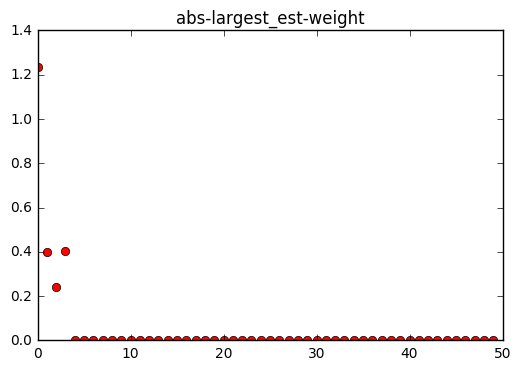

Saved predictions into output/hist200_adaboosting_AdaBoost_est50_Lasso_alpha15.csv


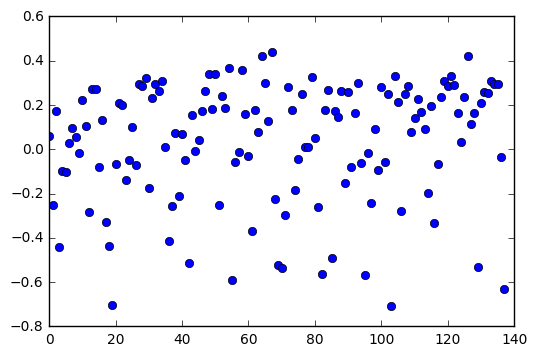

Saved age diagrams as output/hist200_adaboosting_AdaBoost_est50_Lasso_alpha15*.png


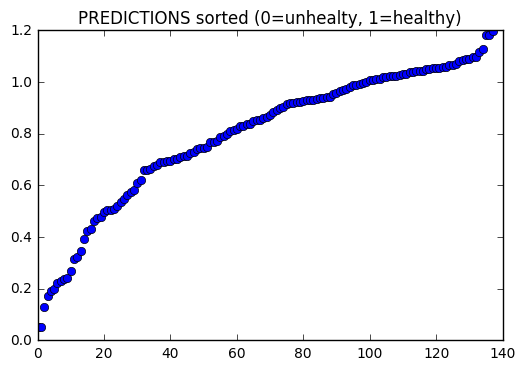

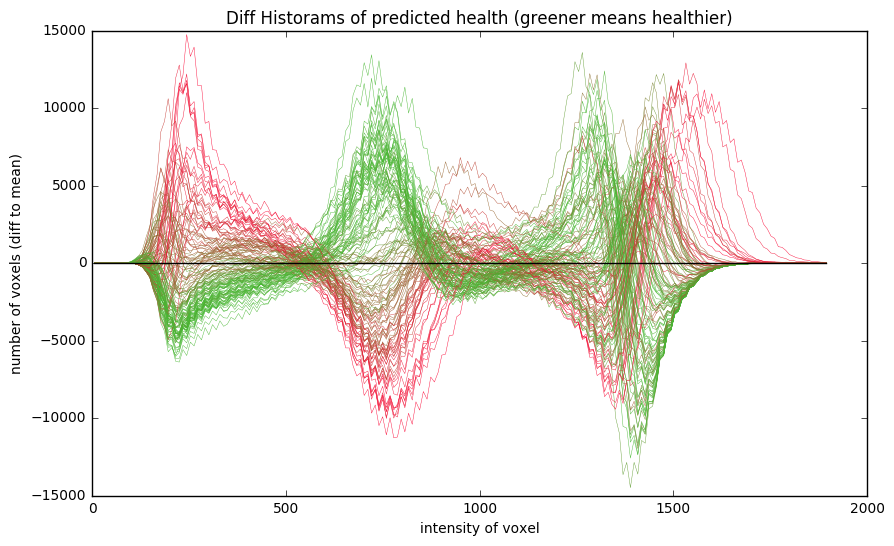

 ========= x ========== 
[[  1.50725930e+09   1.22970297e+06   1.17935264e+05   2.33937207e+02
    1.79972709e+05]
 [  1.51397922e+09   1.24338078e+06   1.19807807e+05   2.34980187e+02
    1.84733726e+05]
 [  1.52006085e+09   1.25454241e+06   1.20887034e+05   2.35924098e+02
    1.88616544e+05]
 [  1.50325552e+09   1.26674992e+06   1.23543225e+05   2.33315794e+02
    1.94617539e+05]
 [  1.51991516e+09   1.24841167e+06   1.20102921e+05   2.35901486e+02
    1.86245570e+05]] ...

 ========= y_t_pp ========== 
[0.81847203546605418, 0.50573795172474623, 0.9309096894793456, 0.31717664638699117, 0.65878801494522077] ...

Variables available in 'result'


In [13]:
doStuff(n_est=50)

# Histogram deviation from mean and Lasso coefficients

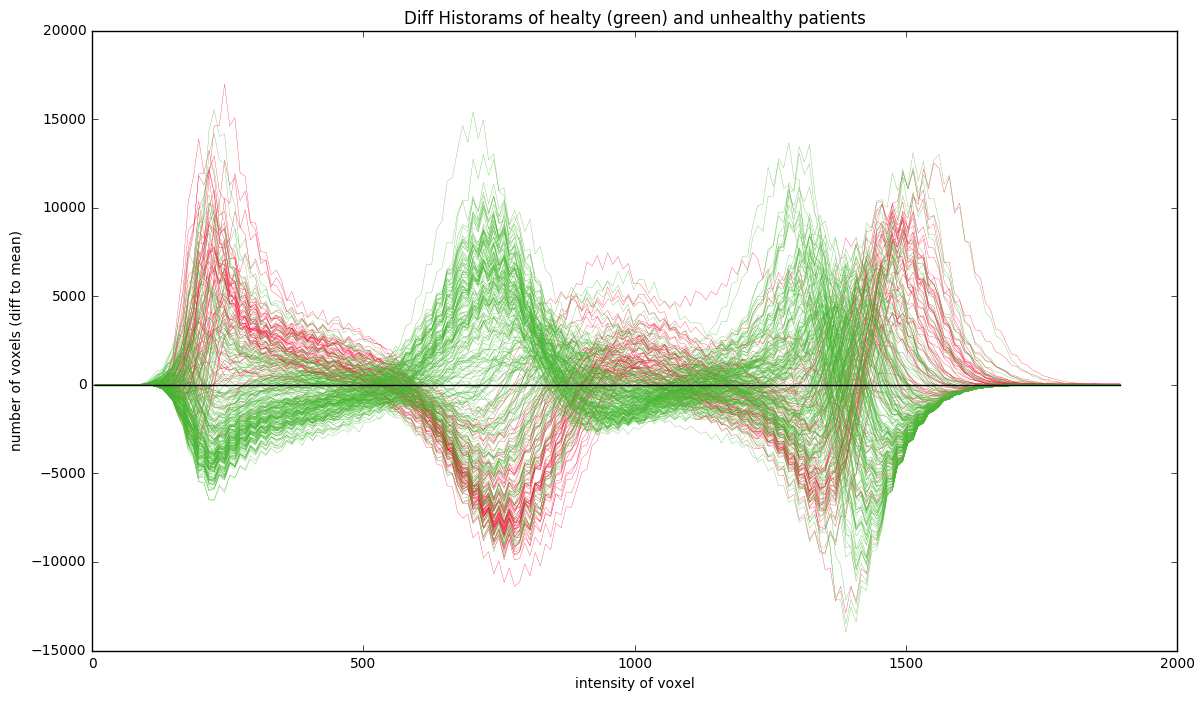

In [9]:
plt.clf()
g = "hist_viz_" + str(space)
fig = plt.figure(1)
fig.set_size_inches(14,8)
sortI = range(0,n_max)
sortI.sort(key=lambda i:y[i])
dos = sortI
for si,i in enumerate(dos):
    s = "i=%s,healthy=%s" % (i,y[i])
    c = pred_to_rgb(y[i])
    plt.plot(sbins,x[i,iHist:],color=c,linewidth=0.2)
plt.plot(sbins,x[0,iHist:]*0,color="black",linewidth=1)
plt.ylabel("number of voxels (diff to mean)")
plt.xlabel("intensity of voxel")
plt.title("Diff Historams of healty (green) and unhealthy patients")
plt.savefig(g + ".png")
plt.show()

## Visualize all Histograms deviations per Age

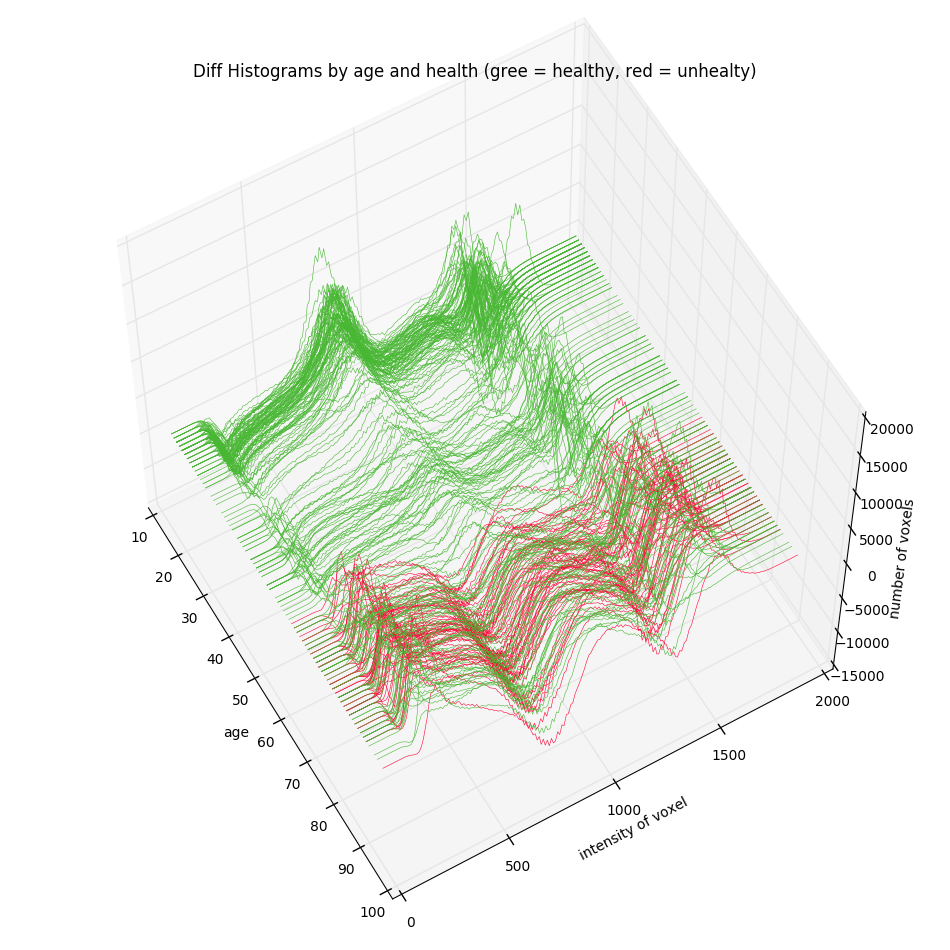

In [10]:
from mpl_toolkits.mplot3d import Axes3D

plt.clf()
fig = plt.figure()
fig.set_size_inches(12,12)
ax = fig.gca(projection='3d')
tr = np.arange(0,len(sbins))
for i in range(0,n_max):
    i=sortI[i]
    Z = x[i,iHist:] # Nvoxels
    Y = sbins# intensity
    X = tr*0+y_age[i] # age
    c = pred_to_rgb(y[i])
    ax.plot(X,Y,zs=Z,linewidth=0.4,color=c)
ax.set_xlabel("age")
ax.set_ylabel("intensity of voxel")
ax.set_zlabel("number of voxels")
ax.view_init(elev=60, azim=330)
plt.title("Diff Histograms by age and health (gree = healthy, red = unhealty)")
fig.savefig("all-histograms-by-health-and-age_"+str(space)+".png")
plt.show()

In [22]:
result[3]

array([ 0.81847204,  0.50573795,  0.93090969,  0.31717665,  0.65878801,
        0.65853494,  0.78674158,  0.85413387,  0.8161635 ,  0.74410004,
        0.98012556,  0.86574596,  0.47575669,  1.03257789,  1.0320742 ,
        0.67692366,  0.89306248,  0.43085838,  0.32330623,  0.05377276,
        0.69055024,  0.96929319,  0.95686   ,  0.61931571,  0.71027939,
        0.8596436 ,  0.68943532,  1.05330405,  1.04323238,  1.08168815,
        0.58241529,  0.98941415,  1.0549778 ,  1.02249065,  1.0669766 ,
        0.76781516,  0.34557697,  0.5036187 ,  0.8304998 ,  0.54938814,
        0.8294184 ,  0.7123324 ,  0.24362318,  0.91444597,  0.75013124,
        0.79937574,  0.93040339,  1.02289945,  1.09900176,  0.94116277,
        1.09703621,  0.50893811,  0.99913353,  0.94345402,  1.12660423,
        0.17037343,  0.70283305,  0.74629717,  1.11564053,  0.91921816,
        0.73010714,  0.39167464,  0.93789409,  0.83643549,  1.18114375,
        1.05861033,  0.88472935,  1.19744757,  0.53535786,  0.23